In [1]:
%pylab inline 

from __future__ import division

import os
import copy
import warnings

import numpy as np

import scipy
from scipy.interpolate import interp1d

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.cosmology import WMAP9 as cosmo
# AstroML
from astroML.plotting import hist

rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 2.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 2.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 2.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 2.5

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator

Populating the interactive namespace from numpy and matplotlib


In [3]:
def decideCutoutSize(z, safe=False):

    """
    Decide the typical cutout size for certain redshift
    """

    if (z <= 0.15):
        if safe:
            return 1000
        else:
            return 1200
    if (z > 0.15) and (z < 0.25):
        if safe:
            return 650
        else:
            return 750
    if (z > 0.25) and (z < 0.35):
        if safe:
            return 550
        else:
            return 600
    if (z > 0.35) and (z < 0.45):
        if safe:
            return 350
        else:
            return 400
    if (z > 0.45) and (z < 0.65):
        if safe:
            return 300
        else:
            return 350
    if (z > 0.65):
        if safe:
            return 200
        else:
            return 250

# The Master redMapper Catalogs

In [4]:
loc = '/Users/songhuang/Dropbox/work/hscs/redmapper/redmapper/'

# Cluster and BCG catalog
catC = os.path.join(loc, 'redmapper_dr8_public_v5.10_catalog_flat.fits')
# Member catalog
catM = os.path.join(loc, 'redmapper_dr8_public_v5.10_members_combined.fits')

redC = Table.read(catC, format='fits')
redM = Table.read(catM, format='fits')

In [5]:
redC.colnames

['ID_CLUSTER',
 'NAME',
 'RA_BCG',
 'DEC_BCG',
 'Z_LAMBDA',
 'Z_LAMBDA_ERR',
 'LAMBDA_CLUSTER',
 'LAMBDA_ERR_CLUSTER',
 'S_CLUSTER',
 'Z_SPEC_BCG',
 'OBJID_BCG',
 'IMAG_BCG',
 'IMAG_ERR_BCG',
 'MODEL_MAG_u_BCG',
 'MODEL_MAG_g_BCG',
 'MODEL_MAG_r_BCG',
 'MODEL_MAG_i_BCG',
 'MODEL_MAG_z_BCG',
 'MODEL_MAGERR_u_BCG',
 'MODEL_MAGERR_g_BCG',
 'MODEL_MAGERR_r_BCG',
 'MODEL_MAGERR_i_BCG',
 'MODEL_MAGERR_z_BCG',
 'ILUM_BCG',
 'PZBINS_1',
 'PZBINS_2',
 'PZBINS_3',
 'PZ_1',
 'PZ_2',
 'PZ_3',
 'P_CEN_1',
 'P_CEN_2',
 'P_CEN_3',
 'P_CEN_4',
 'P_CEN_5',
 'RA_CEN_1',
 'RA_CEN_2',
 'RA_CEN_3',
 'RA_CEN_4',
 'RA_CEN_5',
 'DEC_CEN_1',
 'DEC_CEN_2',
 'DEC_CEN_3',
 'DEC_CEN_4',
 'DEC_CEN_5',
 'ID_CEN_1',
 'ID_CEN_2',
 'ID_CEN_3',
 'ID_CEN_4',
 'ID_CEN_5']

In [6]:
redM.colnames

['ID_CLUSTER',
 'RA_MEM',
 'DEC_MEM',
 'R_MEM',
 'P_MEM',
 'P_SPEC',
 'P_FREE',
 'THETA_I_MEM',
 'THETA_R_MEM',
 'IMAG_MEM',
 'IMAG_ERR_MEM',
 'MODEL_MAG_u_MEM',
 'MODEL_MAG_g_MEM',
 'MODEL_MAG_r_MEM',
 'MODEL_MAG_i_MEM',
 'MODEL_MAG_z_MEM',
 'MODEL_MAGERR_u_MEM',
 'MODEL_MAGERR_g_MEM',
 'MODEL_MAGERR_r_MEM',
 'MODEL_MAGERR_i_MEM',
 'MODEL_MAGERR_z_MEM',
 'Z_SPEC_MEM',
 'OBJID_MEM',
 'NAME',
 'RA_BCG',
 'DEC_BCG',
 'Z_LAMBDA',
 'Z_LAMBDA_ERR',
 'LAMBDA_CLUSTER',
 'LAMBDA_ERR_CLUSTER',
 'S_CLUSTER',
 'Z_SPEC_BCG',
 'OBJID_BCG',
 'IMAG_BCG',
 'IMAG_ERR_BCG',
 'MODEL_MAG_u_BCG',
 'MODEL_MAG_g_BCG',
 'MODEL_MAG_r_BCG',
 'MODEL_MAG_i_BCG',
 'MODEL_MAG_z_BCG',
 'MODEL_MAGERR_u_BCG',
 'MODEL_MAGERR_g_BCG',
 'MODEL_MAGERR_r_BCG',
 'MODEL_MAGERR_i_BCG',
 'MODEL_MAGERR_z_BCG',
 'ILUM_BCG',
 'PZBINS_1',
 'PZ_1',
 'P_CEN_1',
 'GroupID',
 'GroupSize']

## The redMapper Clusters that have HSC data (1509)

In [7]:
catCHsc = '/Users/songhuang/Dropbox/work/hscs/redmapper/1509/hsc_redmapper_cluster_1509.fits'
catMHsc = '/Users/songhuang/Dropbox/work/hscs/redmapper/1509/hsc_redmapper_member_1509.fits'

redCHsc = Table.read(catCHsc, format='fits')
redMHsc = Table.read(catMHsc, format='fits')

In [8]:
# definitions for the axes
recScat  = [0.1, 0.1,  0.72, 0.72]
recHist1 = [0.1, 0.82, 0.72, 0.17]
recHist2 = [0.82, 0.1, 0.17, 0.72]

# Plot some basic properties of the sample

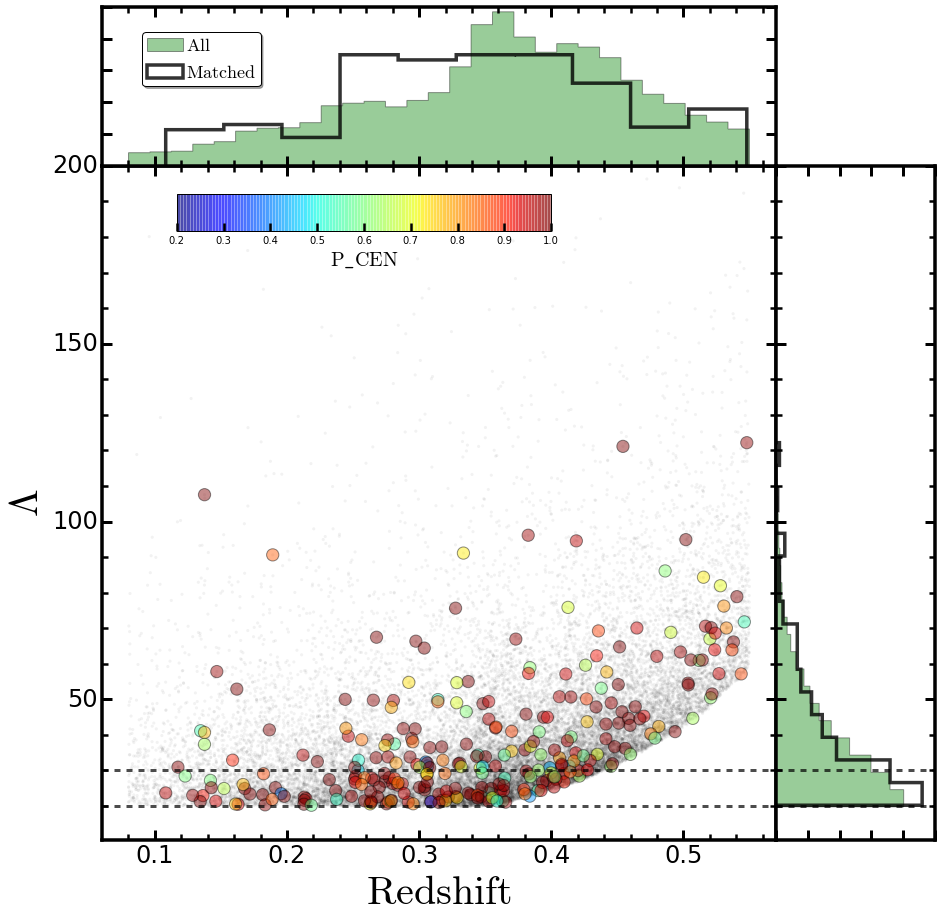

In [25]:
fig = plt.figure(figsize=(13, 13))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist1)
ax3 = plt.axes(recHist2)

# ---------------------------------------------------------------------------
# Scatter plot

ax1.axhline(20.0, linewidth=3.0, linestyle='dashed', c='k', 
            alpha=0.7)
ax1.axhline(30.0, linewidth=3.0, linestyle='dashed', c='k', 
            alpha=0.7)

# Matched ones 
ax1.scatter(redC['Z_LAMBDA'], redC['LAMBDA_CLUSTER'], s=10.0, 
            alpha=0.05, facecolor='k', edgecolor='none',
            label='All redMapper')

p = ax1.scatter(redCHsc['Z_LAMBDA'], redCHsc['LAMBDA_CLUSTER'], 
                c=redCHsc['P_CEN_1'], s=150.0, alpha=0.45, 
                label='HSC DR15A', vmin=0.2, vmax=1.00)

# Color bar 
cax = fig.add_axes([0.18, 0.75, 0.4, 0.04]) 
cb = plt.colorbar(p, orientation="horizontal", cax=cax)
cb.ax.set_xlabel('$\mathrm{P}\_\mathrm{CEN}$', fontsize=20)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\mathrm{Redshift}$',    size=40)
ax1.set_ylabel( '$\Lambda$', size=40)
# Axis limits
ax1.set_xlim(0.06, 0.57)
ax1.set_ylim(10.5, 200.0)


# ---------------------------------------------------------------------------
# Histogram 1 
hist(redC['Z_LAMBDA'], bins='knuth', ax=ax2, orientation='vertical', 
     histtype='stepfilled', color='g', alpha=0.4, normed=1,
     label='$\mathrm{All}$')
hist(redCHsc['Z_LAMBDA'], bins='knuth', ax=ax2, orientation='vertical', 
     histtype='step', color='k', alpha=0.8, normed=1, linewidth=3.5,
     label='$\mathrm{Matched}$')

#ax2.axvline(0.32, linewidth=2.5, linestyle='dashed', c='k', 
#            alpha=0.7)
ax2.set_xlim(ax1.get_xlim())

ax2.legend(loc=(0.06, 0.50), shadow=True, fancybox=True, 
           numpoints=1, fontsize=18, scatterpoints=1, 
           markerscale=0.9, borderpad=0.25, handletextpad=0.2)

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()
ax2.tick_params(axis='y', which='minor', left='off', right='off')

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')

ax2.axhline(0.0, color='k', linewidth=2, linestyle='--')

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

# ---------------------------------------------------------------------------
# Histogram 2
hist(redC['LAMBDA_CLUSTER'], bins='knuth', orientation='horizontal', 
     histtype='stepfilled', color='g', alpha=0.4, normed=1, ax=ax3)
hist(redCHsc['LAMBDA_CLUSTER'], bins='knuth', orientation='horizontal', 
     histtype='step', color='k', alpha=0.8, normed=1, linewidth=3.5, 
     label='HSC Matched', ax=ax3)

ax3.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax3.minorticks_on()
ax3.tick_params(axis='x', which='minor', bottom='off', top='off')

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax3.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax3.tick_params('both', length=10, width=3.0, which='major')

#ax3.axhline(0.0, color='k', linewidth=2, linestyle='--')
ax3.axhline(20.0, linewidth=3.0, linestyle='dashed', c='k', 
            alpha=0.7)
ax3.axhline(30.0, linewidth=3.0, linestyle='dashed', c='k', 
            alpha=0.7)

ax3.yaxis.set_major_formatter(NullFormatter())
ax3.xaxis.set_major_formatter(NullFormatter())

fig.savefig('../figure/redmapper_redshift_lambda_1.png', dpi=300)

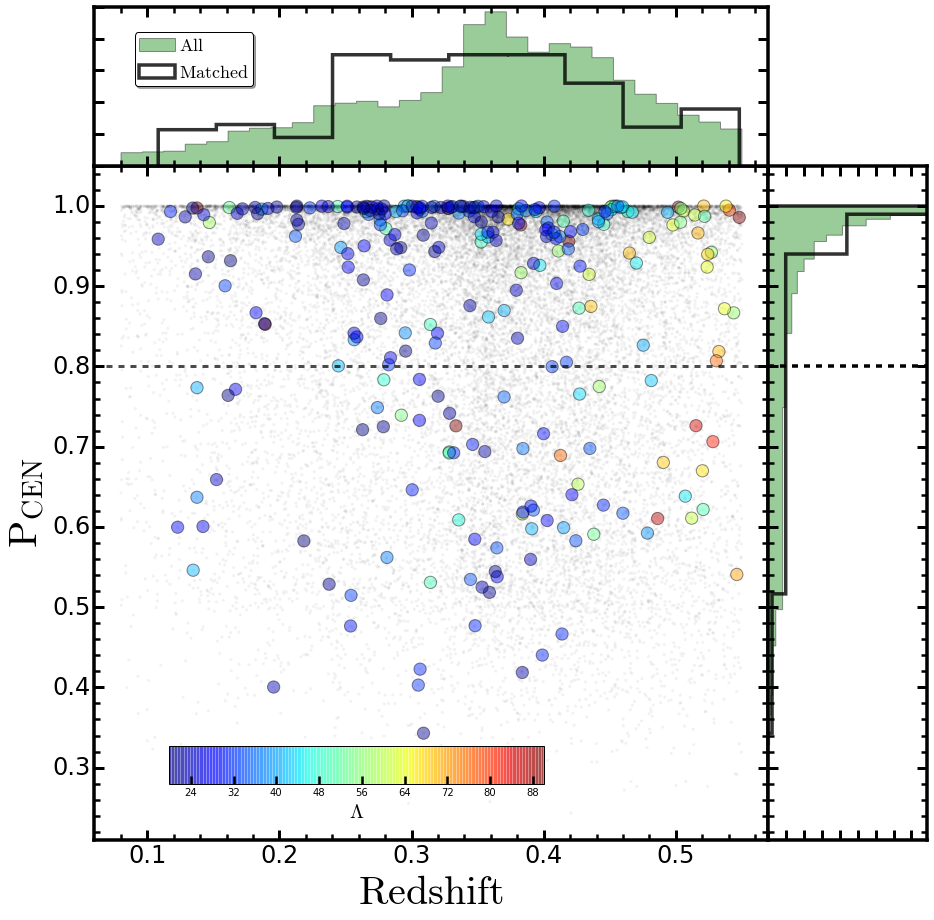

In [27]:
fig = plt.figure(figsize=(13, 13))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist1)
ax3 = plt.axes(recHist2)

# ---------------------------------------------------------------------------
# Scatter plot

#ax1.axvline(0.32, linewidth=2.5, linestyle='dashed', c='k', alpha=0.7)
ax1.axhline(0.80, linewidth=3.0, linestyle='dashed', c='k', 
            alpha=0.7)
    
# Matched ones 
ax1.scatter(redC['Z_LAMBDA'], redC['P_CEN_1'], s=10.0, 
            alpha=0.05, facecolor='k', edgecolor='none',
            label='All redMapper')

p = ax1.scatter(redCHsc['Z_LAMBDA'], redCHsc['P_CEN_1'], 
                c=redCHsc['LAMBDA_CLUSTER'], s=150.0, alpha=0.45, 
                label='HSC DR15A', vmin=20, vmax=90)

# Color bar 
cax = fig.add_axes([0.18, 0.16, 0.4, 0.04]) 
cb = plt.colorbar(p, orientation="horizontal", cax=cax)
cb.ax.set_xlabel('$\Lambda$', fontsize=20)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\mathrm{Redshift}$', size=40)
ax1.set_ylabel('$\mathrm{P}_\mathrm{CEN}$',  size=40)
# Axis limits
ax1.set_xlim(0.06, 0.57)
ax1.set_ylim(0.21, 1.05)


# ---------------------------------------------------------------------------
# Histogram 1 
hist(redC['Z_LAMBDA'], bins='knuth', ax=ax2, orientation='vertical', 
     histtype='stepfilled', color='g', alpha=0.4, normed=1, 
     label='$\mathrm{All}$')
hist(redCHsc['Z_LAMBDA'], bins='knuth', ax=ax2, orientation='vertical', 
     histtype='step', color='k', alpha=0.8, normed=1, linewidth=3.5,
     label='$\mathrm{Matched}$')

#ax2.axvline(0.32, linewidth=2.5, linestyle='dashed', c='k', 
#            alpha=0.7)
ax2.set_xlim(ax1.get_xlim())

ax2.legend(loc=(0.06, 0.50), shadow=True, fancybox=True, 
           numpoints=1, fontsize=18, scatterpoints=1, 
           markerscale=0.9, borderpad=0.25, handletextpad=0.2)

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()
ax2.tick_params(axis='y', which='minor', left='off', right='off')

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')

#ax2.axhline(0.0, color='k', linewidth=2, linestyle='--')

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

# ---------------------------------------------------------------------------
# Histogram 2
hist(redC['P_CEN_1'], bins='blocks', ax=ax3, orientation='horizontal', 
     histtype='stepfilled', color='g', alpha=0.4, normed=1)
hist(redCHsc['P_CEN_1'], bins='blocks', ax=ax3, orientation='horizontal', 
     histtype='step', color='k', alpha=0.8, normed=1, linewidth=3.5, 
     label='HSC Matched')

ax3.set_xlim(0.0, 8.9)
ax3.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax3.minorticks_on()
ax3.tick_params(axis='x', which='minor', bottom='off', top='off')

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax3.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax3.tick_params('both', length=10, width=3.0, which='major')
ax3.tick_params('both', length=6, width=2.5, which='minor')

ax3.axhline(0.8, color='k', linewidth=3.5, linestyle='--')

ax3.yaxis.set_major_formatter(NullFormatter())
ax3.xaxis.set_major_formatter(NullFormatter())

fig.savefig('../figure/redmapper_redshift_pcen1_1.png', dpi=300)

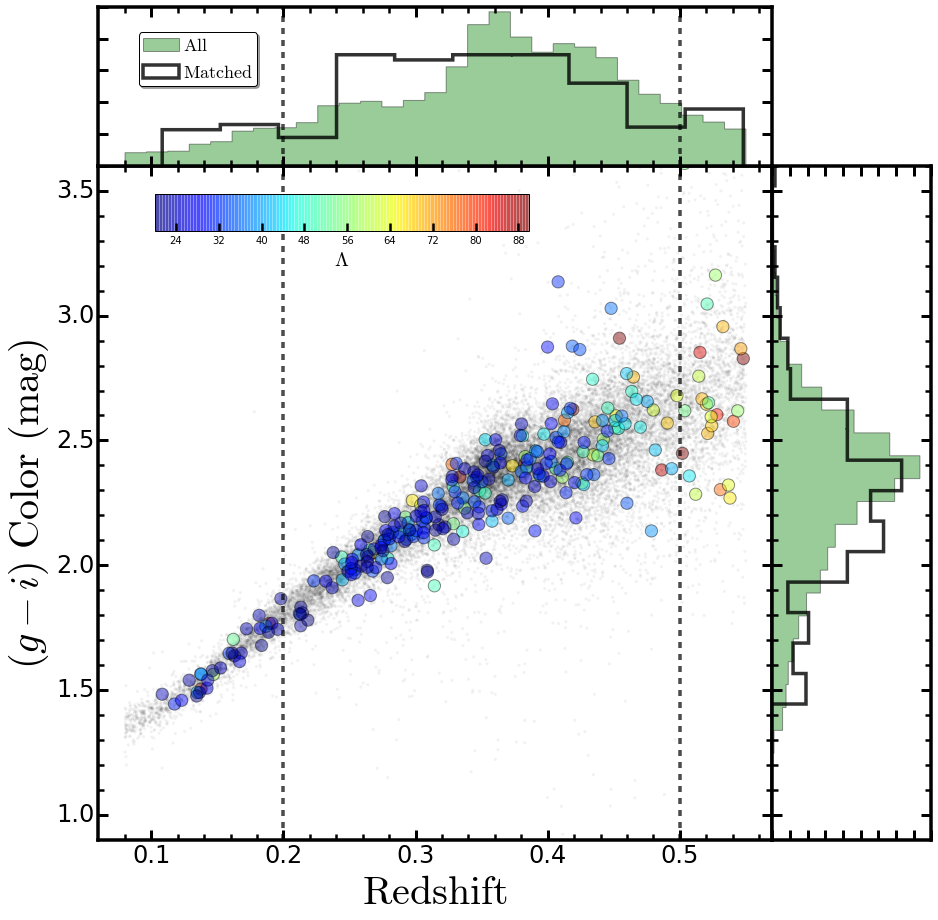

In [32]:
fig = plt.figure(figsize=(13, 13))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist1)
ax3 = plt.axes(recHist2)

# ---------------------------------------------------------------------------
# Scatter plot

ax1.axvline(0.20, linewidth=3.5, linestyle='dashed', c='k', 
            alpha=0.7)
ax1.axvline(0.50, linewidth=3.5, linestyle='dashed', c='k', 
            alpha=0.7)

# Matched ones 
ax1.scatter(redC['Z_LAMBDA'], (redC['MODEL_MAG_g_BCG'] - redC['MODEL_MAG_i_BCG']), s=10.0, 
            alpha=0.05, facecolor='k', edgecolor='none', label='All redMapper')

p = ax1.scatter(redCHsc['Z_LAMBDA'], (redCHsc['MODEL_MAG_g_BCG'] - redCHsc['MODEL_MAG_i_BCG']), 
                c=redCHsc['LAMBDA_CLUSTER'], s=150.0, alpha=0.45, 
                label='HSC DR15A', vmin=20, vmax=90)

# Color bar 
cax = fig.add_axes([0.16, 0.75, 0.40, 0.04]) 
cb = plt.colorbar(p, orientation="horizontal", cax=cax)
cb.ax.set_xlabel(r'$\Lambda$', fontsize=20)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\mathrm{Redshift}$', size=40)
ax1.set_ylabel('$(g-i)\ \mathrm{Color}\ (\mathrm{mag})$',  size=40)
# Axis limits
ax1.set_xlim(0.06, 0.57)
ax1.set_ylim(0.90, 3.60)


# ---------------------------------------------------------------------------
# Histogram 1 
hist(redC['Z_LAMBDA'], bins='knuth', ax=ax2, orientation='vertical', 
     histtype='stepfilled', color='g', alpha=0.4, normed=1,
     label='$\mathrm{All}$')
hist(redCHsc['Z_LAMBDA'], bins='knuth', ax=ax2, orientation='vertical', 
     histtype='step', color='k', alpha=0.8, normed=1, linewidth=3.5,
     label='$\mathrm{Matched}$')

ax2.axvline(0.2, linewidth=3.5, linestyle='dashed', c='k', 
            alpha=0.7)
ax2.axvline(0.5, linewidth=3.5, linestyle='dashed', c='k', 
            alpha=0.7)

ax2.set_xlim(ax1.get_xlim())

ax2.legend(loc=(0.06, 0.50), shadow=True, fancybox=True, 
           numpoints=1, fontsize=18, scatterpoints=1, 
           markerscale=0.9, borderpad=0.25, handletextpad=0.2)

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()
ax2.tick_params(axis='y', which='minor', left='off', right='off')

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')

ax2.axhline(0.0, color='k', linewidth=2, linestyle='--')

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

# ---------------------------------------------------------------------------
# Histogram 2
hist((redC['MODEL_MAG_g_BCG'] - redC['MODEL_MAG_i_BCG']), bins='knuth', ax=ax3, 
     orientation='horizontal', histtype='stepfilled', 
     color='g', alpha=0.4, normed=1)
hist((redCHsc['MODEL_MAG_g_BCG'] - redCHsc['MODEL_MAG_i_BCG']), bins='knuth', ax=ax3, 
     orientation='horizontal', histtype='step', 
     color='k', alpha=0.8, normed=1, linewidth=3.5)

ax3.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax3.minorticks_on()
ax3.tick_params(axis='x', which='minor', bottom='off', top='off')

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax3.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax3.tick_params('both', length=10, width=3.0, which='major')
ax3.tick_params('both', length=6, width=2.5, which='minor')

ax3.axhline(0.0, color='k', linewidth=2, linestyle='--')

ax3.yaxis.set_major_formatter(NullFormatter())
ax3.xaxis.set_major_formatter(NullFormatter())

fig.savefig('../figure/redmapper_redshift_gicolor_1.png', dpi=300)

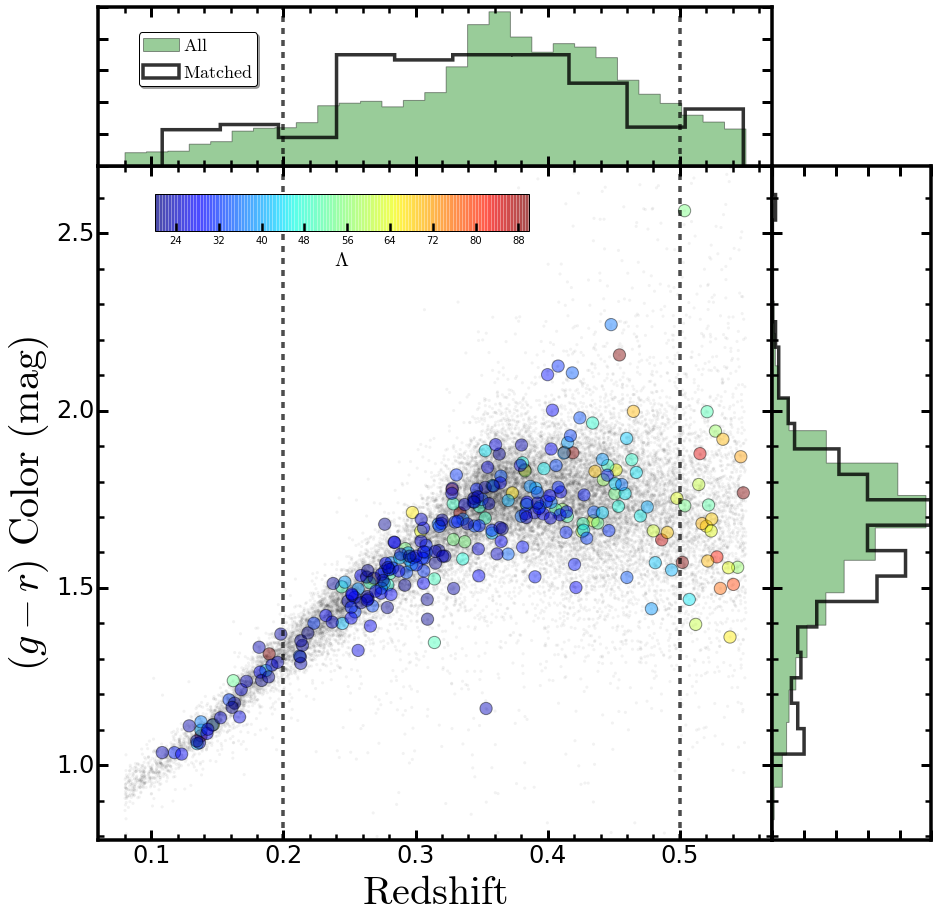

In [33]:
fig = plt.figure(figsize=(13, 13))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist1)
ax3 = plt.axes(recHist2)

# ---------------------------------------------------------------------------
# Scatter plot

ax1.axvline(0.20, linewidth=3.5, linestyle='dashed', c='k', 
            alpha=0.7)
ax1.axvline(0.50, linewidth=3.5, linestyle='dashed', c='k', 
            alpha=0.7)

# Matched ones 
ax1.scatter(redC['Z_LAMBDA'], (redC['MODEL_MAG_g_BCG'] - redC['MODEL_MAG_r_BCG']), s=10.0, 
            alpha=0.05, facecolor='k', edgecolor='none', label='All redMapper')

p = ax1.scatter(redCHsc['Z_LAMBDA'], (redCHsc['MODEL_MAG_g_BCG'] - redCHsc['MODEL_MAG_r_BCG']), 
                c=redCHsc['LAMBDA_CLUSTER'], s=150.0, alpha=0.45, 
                label='HSC DR15A', vmin=20, vmax=90)

# Color bar 
cax = fig.add_axes([0.16, 0.75, 0.40, 0.04]) 
cb = plt.colorbar(p, orientation="horizontal", cax=cax)
cb.ax.set_xlabel(r'$\Lambda$', fontsize=20)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('$\mathrm{Redshift}$', size=40)
ax1.set_ylabel('$(g-r)\ \mathrm{Color}\ (\mathrm{mag})$',  size=40)
# Axis limits
ax1.set_xlim(0.06, 0.57)
ax1.set_ylim(0.79, 2.69)


# ---------------------------------------------------------------------------
# Histogram 1 
hist(redC['Z_LAMBDA'], bins='knuth', ax=ax2, orientation='vertical', 
     histtype='stepfilled', color='g', alpha=0.4, normed=1,
     label='$\mathrm{All}$')
hist(redCHsc['Z_LAMBDA'], bins='knuth', ax=ax2, orientation='vertical', 
     histtype='step', color='k', alpha=0.8, normed=1, linewidth=3.5,
     label='$\mathrm{Matched}$')

ax2.axvline(0.2, linewidth=3.5, linestyle='dashed', c='k', 
            alpha=0.7)
ax2.axvline(0.5, linewidth=3.5, linestyle='dashed', c='k', 
            alpha=0.7)

ax2.set_xlim(ax1.get_xlim())

ax2.legend(loc=(0.06, 0.50), shadow=True, fancybox=True, 
           numpoints=1, fontsize=18, scatterpoints=1, 
           markerscale=0.9, borderpad=0.25, handletextpad=0.2)

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()
ax2.tick_params(axis='y', which='minor', left='off', right='off')

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')

ax2.axhline(0.0, color='k', linewidth=2, linestyle='--')

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

# ---------------------------------------------------------------------------
# Histogram 2
hist((redC['MODEL_MAG_g_BCG'] - redC['MODEL_MAG_r_BCG']), bins='knuth', ax=ax3, 
     orientation='horizontal', histtype='stepfilled', 
     color='g', alpha=0.4, normed=1)
hist((redCHsc['MODEL_MAG_g_BCG'] - redCHsc['MODEL_MAG_r_BCG']), bins='knuth', ax=ax3, 
     orientation='horizontal', histtype='step', 
     color='k', alpha=0.8, normed=1, linewidth=3.5)

ax3.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax3.minorticks_on()
ax3.tick_params(axis='x', which='minor', bottom='off', top='off')

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax3.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax3.tick_params('both', length=10, width=3.0, which='major')
ax3.tick_params('both', length=6, width=2.5, which='minor')

ax3.axhline(0.0, color='k', linewidth=2, linestyle='--')

ax3.yaxis.set_major_formatter(NullFormatter())
ax3.xaxis.set_major_formatter(NullFormatter())

fig.savefig('../figure/redmapper_redshift_grcolor_1.png', dpi=300)

# Distribution of Galaxies within the Cluster

In [36]:
def bcgDominace(inputC, catM, verbose=False):
    """
    Estimate the BCG dominace
    """
    filterList = ['u', 'g', 'r', 'i', 'z']
    nCluster = len(inputC)
    catC = copy.deepcopy(inputC)
    
    for filter in filterList:
        if verbose: 
            print '## Dearling with %s band now! \n' % filter 
        bcgGap = Column(np.arange(nCluster, dtype='float32'), name='bcgGap_' + filter)
        bcgDom = Column(np.arange(nCluster, dtype='float32'), name='bcgDom_' + filter)
        bcgFrac5 = Column(np.arange(nCluster, dtype='float32'), name='bcgFrac5_' + filter)
        bcgFracA = Column(np.arange(nCluster, dtype='float32'), name='bcgFracA_' + filter)

        for (ii, useC) in enumerate(catC):
        
            idCluster = useC['ID_CLUSTER']    
            useM = catM[catM['ID_CLUSTER'] == idCluster]
            if verbose:
                print "### %d - ID of the Cluster : %d" %  (ii+1, idCluster)
    
            magC = useC['MODEL_MAG_' + filter + '_BCG']
            magM = np.sort(useM['MODEL_MAG_' + filter + '_MEM'],
                           kind='mergesort')
            fracMem = map(lambda x: 10.0 ** (0.4 * (magC - x)), magM)
            nMem = len(magM)
            
            if verbose:
                print magM[1], magC, magM[1] - magC

            if np.isclose(magC, magM[0], atol=0.0001):
                bcgGap[ii] = (magM[1] - magC)
                if nMem >= 6: 
                    bcgDom[ii] = np.nanmean(magM[1:6]) - magC
                    bcgFrac5[ii] = 1.0 / np.sum(fracMem[1:6])
                else:
                    bcgDom[ii] = np.nanmean(magM[1:]) - magC
                    bcgFrac5[ii] = np.nan
                bcgFracA[ii] = 1.0 / np.sum(fracMem[1:])
                if verbose:
                    print bcgGap[ii], bcgDom[ii], bcgFrac5[ii], bcgFracA[ii]
            elif np.any(np.isclose(magC, magM, atol=0.0001)):
                warnings.warn('# BCG is not the brightest galaxy in this filter!')
                bcgGap[ii], bcgDom[ii], bcgFrac5[ii], bcgFracA[ii] = -9999.0, -9999.0, -9999.0, -9999.0
            else: 
                raise Exception('# BCG is not in the catalog?')
        catC.add_columns([bcgGap, bcgDom, bcgFrac5, bcgFracA])
            
    return catC

In [37]:
newCHsc = bcgDominace(redCHsc, redMHsc)

newCHsc.write(catCHsc.replace('.fits', '_gap.fits'), format='fits', 
             overwrite=True)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:45: UserWarning: # BCG is not the brightest galaxy in this filter!


In [38]:
if os.path.isfile(catC.replace('.fits', '_gap.fits')):
    newC = Table.read(catC.replace('.fits', '_gap.fits'), format='fits')
else:
    warnings.warn('# Will take a long time!')
    newC = bcgDominace(redC, redM)
    newC.write(catC.replace('.fits', '_gap.fits'), format='fits', 
                 overwrite=True)

# Plot the RA, DEC distribution of each cluster and Other Information

In [41]:
def redMapperPlotRaDec(redC, redM, id, loc='', verbose=True):
    """
    Plot the Ra, DEC distributions of galaxies in a redMapper cluster
    """
    
    if verbose:
        print "########################################################################"
        print " Cluster ID : %i" % id
    useC = redC[redC['ID_CLUSTER'] == id]
    useM = redM[redM['ID'] == id]

    fig = plt.figure(figsize=(12.5, 12))
    fig.subplots_adjust(left=0.14, right=0.99, bottom=0.09, top=0.99)
    ax1 = fig.add_subplot(111)

    maxMag_r = np.nanmax(useM['MODEL_MAG_r_MEM']) + 0.05

    grColor = (useM['MODEL_MAG_g_MEM'] - useM['MODEL_MAG_r_MEM'])
    grBCG   = (useC['MODEL_MAG_g_BCG'] - useC['MODEL_MAG_r_BCG'])
    grMin = np.nanmin(grColor)
    grMax = np.nanmax(grColor)
    if grMin <= 0.5: 
        grMin = 0.5
    if grMax - grBCG >= 0.1: 
        grMax = grBCG + 0.1

    p = ax1.scatter(useM['RA_MEM'], useM['DEC_MEM'], marker='o', c=grColor, 
                    s=(maxMag_r - useM['MODEL_MAG_r_MEM'])*120, alpha=0.45,
                    vmin=grMin, vmax=grMax, label=None)
    ax1.grid()

    ax1.scatter(useC['RA_BCG'], useC['DEC_BCG'], marker='+', color='k', 
                s=(maxMag_r - useC['MODEL_MAG_r_BCG'])*160, alpha=0.9, 
                facecolor='k', linewidth=4.5, label='$\mathrm{CEN\_1}$')

    ax1.scatter(useC['RA_CEN_2'], useC['DEC_CEN_2'], marker='s', color='k', 
                s=170, alpha=0.8, facecolor='none', linewidth=4, label='$\mathrm{CEN\_2}$')
    ax1.scatter(useC['RA_CEN_3'], useC['DEC_CEN_3'], marker='2', color='k', 
                s=400, alpha=0.8, facecolor='k', linewidth=4, label='$\mathrm{CEN\_3}$')
    ax1.scatter(useC['RA_CEN_4'], useC['DEC_CEN_4'], marker='o', color='k', 
                s=260, alpha=0.8, facecolor='none', linewidth=4, label='$\mathrm{CEN\_4}$')
    ax1.scatter(useC['RA_CEN_5'], useC['DEC_CEN_5'], marker='x', color='k', 
                s=260, alpha=0.8, facecolor='k', linewidth=4, label='$\mathrm{CEN\_5}$')

    # Axes setup
    #  Minor Ticks on 
    ax1.minorticks_on()
    #  Axes Thickness
    for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(3.5)
    #  Tick Label Size 
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    #  Tick Length and Width
    ax1.tick_params('both', length=10, width=3.0, which='major')
    ax1.tick_params('both', length=6, width=2.5, which='minor')
    
    # X/Y Axis Label
    ax1.set_xlabel('$\mathrm{RA}\ \mathrm{[deg]}$', size=34)
    ax1.set_ylabel('$\mathrm{DEC}\ \mathrm{[deg]}$', size=34)

    # X/Y Axis Limits
    raSep  = np.max(useM['RA_MEM'])  - np.min(useM['RA_MEM'])
    decSep = np.max(useM['DEC_MEM']) - np.min(useM['DEC_MEM'])
    if raSep >= decSep: 
        radC = (raSep / 2.0)  + 0.025
    else: 
        radC = (decSep / 2.0) + 0.025 

    ax1.set_xlim((useC['RA_BCG']  - radC), (useC['RA_BCG']  + radC))
    ax1.set_ylim((useC['DEC_BCG'] - radC), (useC['DEC_BCG'] + radC))

    # 1 Mpc radius circle 
    deg_1Mpc = (1000.0 / (cosmo.kpc_proper_per_arcmin(useC['Z_LAMBDA']).value[0] * 60.0))
    cir_1Mpc = plt.Circle((useC['RA_BCG'], useC['DEC_BCG']), deg_1Mpc, color='k', 
                          fill=False, linewidth=3.5, linestyle='dashed', 
                          label='$1\ \mathrm{Mpc}$', alpha=0.8)
    ax1.add_artist(cir_1Mpc)

    # 250 kpc radius circle 
    deg_250kpc = (250.0 / (cosmo.kpc_proper_per_arcmin(useC['Z_LAMBDA']).value[0] * 60.0))
    cir_250kpc = plt.Circle((useC['RA_BCG'], useC['DEC_BCG']), deg_250kpc, color='b', 
                          fill=False, linewidth=3.0, linestyle='dashed', 
                          label='$250\ \mathrm{kpc}$', alpha=0.4)
    ax1.add_artist(cir_250kpc)
    
    # Box for the cutout image 
    len_cut = ((decideCutoutSize(useC['Z_LAMBDA'], safe=False) * 0.168) / 3600.0)
    if verbose:
        print " Cluster redshift : %5.2f" % useC['Z_LAMBDA']
        print "                    %5.2f deg per Mpc" % deg_1Mpc
        print " Cutout size : %5.2f deg" % len_cut
        print "             : %5.2f kpc" % (len_cut * 60.0 * cosmo.kpc_proper_per_arcmin(useC['Z_LAMBDA']).value[0])
        print " Largest radius of cluster member : % 5.2f" % np.max(useM['R_MEM'])

    box_cut = plt.Rectangle((useC['RA_BCG']-len_cut, useC['DEC_BCG']-len_cut), 
                            (2.0 * len_cut), (2.0 * len_cut), color='r',
                            fill=False, linewidth=3.0, linestyle='solid', 
                            label='Cutout', alpha=0.6)
    ax1.add_artist(box_cut)

    # Legend
    l_handles, l_labels = ax1.get_legend_handles_labels()
    legend = ax1.legend(l_handles, l_labels, loc=(0.812, 0.80),
                        shadow=True, fancybox=True, 
                        numpoints=1, fontsize=18, scatterpoints=1, 
                        markerscale=0.9, borderpad=0.25, handletextpad=0.1)
    legend.get_frame().set_linewidth(2.0)

    # Color bar 
    cax = fig.add_axes([0.16, 0.95, 0.30, 0.02]) 
    cb = plt.colorbar(p, orientation="horizontal", cax=cax)
    cb.ax.set_xlabel('$(g-r)_{\mathrm{Model,\ SDSS}}\ (mag)$', fontsize=20)

    # Information 1
    ax1.text(0.88, 0.03, 
             'ID = %i \n $z_{\Lambda}$= %5.3f \n $\Lambda$ = %3i \n $P_{\mathrm{CEN},\ 1}$ = %4.2f' % (useC['ID_CLUSTER'],
                                                                                       useC['Z_LAMBDA'],
                                                                                       useC['LAMBDA_CLUSTER'], 
                                                                                       useC['P_CEN_1']),
             verticalalignment='bottom', horizontalalignment='center',
             fontsize=20.0, 
             bbox=dict(facecolor='w', edgecolor='k', 
                       boxstyle='round,pad=0.5', lw=2),
             transform=ax1.transAxes)
    
    # Information 2
    ax1.text(0.17, 0.03, 
             '$\Delta(\mathrm{mag}_2)$ = %6.3f \n $\mathrm{Dominace}$ = %6.3f \n $\mathrm{frac}_{\mathrm{Top5}}$ = %6.3f \n $\mathrm{frac}_{\mathrm{All}}$ = %6.3f' % (useC['bcgGap_r'],
                                                                                          useC['bcgDom_r'],
                                                                                          useC['bcgFrac5_r'], 
                                                                                          useC['bcgFracA_r']),
             verticalalignment='bottom', horizontalalignment='center',
             fontsize=20.0, 
             bbox=dict(facecolor='w', edgecolor='k', 
                       boxstyle='round,pad=0.5', lw=2),
             transform=ax1.transAxes)
    if verbose:
        print "########################################################################"

    # Save PNG figure
    pngName = os.path.join(loc, 'redMapper_' + str(id).strip() + '_radec.png')
    fig.savefig(pngName, dpi=200)
    plt.close(fig)

In [42]:
redMapperPlotRaDec(newCHsc, redMHsc, 378, verbose=False, 
                   loc='../figure')

# Plot the RA, DEC Distributions of Galaxies in the HSC redMapper Clusters

In [43]:
print "Number of clusters with HSC data : %i" % len(newCHsc)

Number of clusters with HSC data : 280


In [44]:
for id in newCHsc['ID_CLUSTER']: 
    redMapperPlotRaDec(newCHsc, redMHsc, id, verbose=False, 
                      loc='/Users/songhuang/Dropbox/work/hscs/redmapper/1509/radec/')

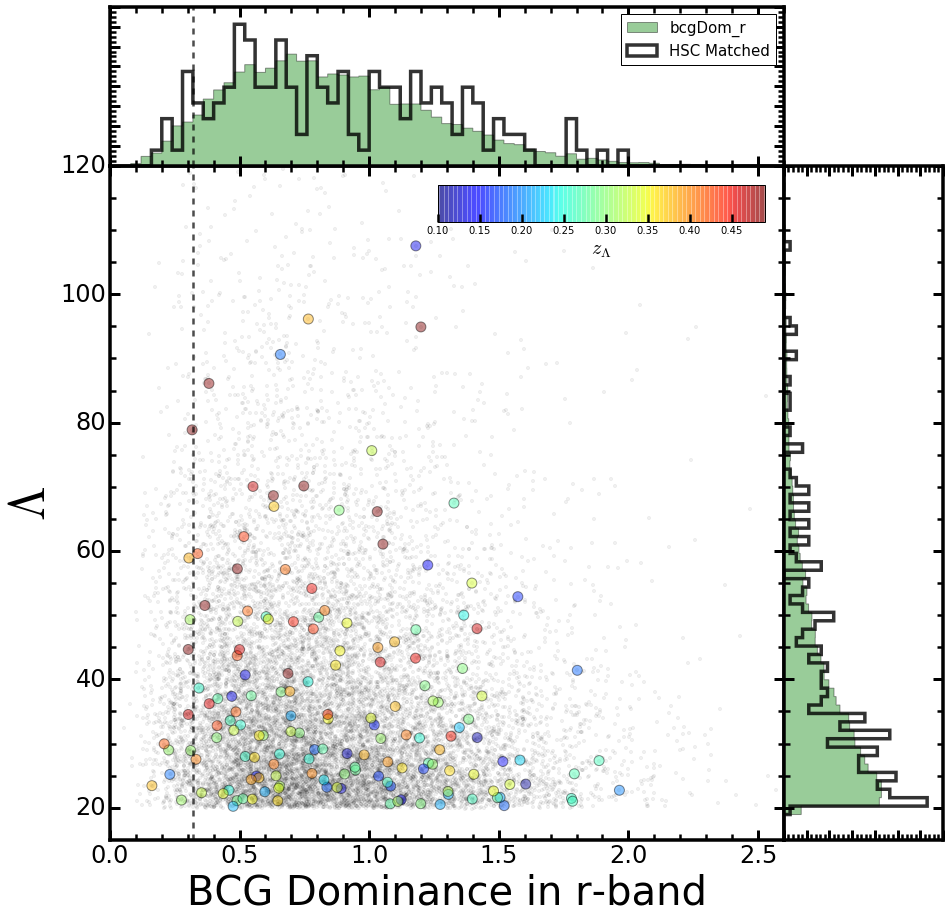

In [179]:
fig = plt.figure(figsize=(13, 13))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist1)
ax3 = plt.axes(recHist2)

# ---------------------------------------------------------------------------
# Scatter plot

ax1.axvline(0.32, linewidth=2.5, linestyle='dashed', c='k', 
            alpha=0.7)

# Matched ones 
ax1.scatter(newC['bcgDom_r'], newC['LAMBDA_CLUSTER'], s=10.0, 
            alpha=0.05, c='k', label='All redMapper')

p = ax1.scatter(newCHsc['bcgDom_r'], newCHsc['LAMBDA_CLUSTER'], 
                c=redCHsc['Z_LAMBDA'], s=100.0, alpha=0.45, 
                label='HSC DR15A', vmin=0.1, vmax=0.49)

# Color bar 
cax = fig.add_axes([0.45, 0.76, 0.35, 0.04]) 
cb = plt.colorbar(p, orientation="horizontal", cax=cax)
cb.ax.set_xlabel(r'$z_{\Lambda}$', fontsize=20)

# Axes setup
#  Minor Ticks on 
ax1.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# Label
ax1.set_xlabel('BCG Dominance in r-band', size=40)
ax1.set_ylabel('$\Lambda$',  size=50)
# Axis limits
ax1.set_xlim(0.0, 2.6)
ax1.set_ylim(15.0, 120.0)


# ---------------------------------------------------------------------------
# Histogram 1 
n, bins, patches=ax2.hist(newC['bcgDom_r'], bins=80, range=[0.0, 3.2], 
                             orientation='vertical', histtype='stepfilled', 
                             color='g', alpha=0.4, normed=1)
n, bins, patches=ax2.hist(newCHsc['bcgDom_r'], bins=80, range=[0.0, 3.2], 
                             orientation='vertical', histtype='step', 
                             color='k', alpha=0.8, normed=1, linewidth=3.5,
                             label='HSC Matched')

ax2.axvline(0.32, linewidth=2.5, linestyle='dashed', c='k', 
            alpha=0.7)
ax2.set_xlim(ax1.get_xlim())

ax2.legend(fontsize=15)

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('both', length=6, width=2.5, which='minor')

ax2.axhline(0.0, color='k', linewidth=2, linestyle='--')

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

# ---------------------------------------------------------------------------
# Histogram 2
n, bins, patches=ax3.hist(newC['LAMBDA_CLUSTER'], bins=80, range=[15, 120], 
                             orientation='horizontal', histtype='stepfilled', 
                             color='g', alpha=0.4, normed=1)
n, bins, patches=ax3.hist(newCHsc['LAMBDA_CLUSTER'], bins=80, range=[15, 120], 
                             orientation='horizontal', histtype='step', 
                             color='k', alpha=0.8, normed=1, linewidth=3.5, 
                             label='HSC Matched')

ax3.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax3.minorticks_on()
#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax3.spines[axis].set_linewidth(3.5)
#  Tick Label Size 
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
#  Tick Length and Width
ax3.tick_params('both', length=10, width=3.0, which='major')
ax3.tick_params('both', length=6, width=2.5, which='minor')

ax3.axhline(0.0, color='k', linewidth=2, linestyle='--')

ax3.yaxis.set_major_formatter(NullFormatter())
ax3.xaxis.set_major_formatter(NullFormatter())

fig.savefig('redmapper_redshift_gicolor_1.png', dpi=90)